# Dependencies

In [1]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not is_kaggle:
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    !pip install -q scikit-learn pandas numpy matplotlib seaborn fastai
    !pip install -q kaggle

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import random

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Prepare Data

Download the data if not in kaggle

In [3]:
competition_name = "commonlit-evaluate-student-summaries"

if is_kaggle:
    input_path = Path(f"/kaggle/input/{competition_name}")
else:
    input_path = Path.home() / ".kaggle" / "input" / competition_name
    !kaggle competitions download -p {input_path.parent} {competition_name}
    !unzip -o {input_path}.zip -d {input_path}

Load the csv files.

In [4]:
summ_train_df = pd.read_csv(input_path / "summaries_train.csv")
summ_test_df = pd.read_csv(input_path / "summaries_test.csv")
prompts_train_df = pd.read_csv(input_path / "prompts_train.csv")
prompts_test_df = pd.read_csv(input_path / "prompts_test.csv")

Merge the summaries and prompts dataframes for both training and testing

In [5]:
train_df = pd.merge(summ_train_df, prompts_train_df, on="prompt_id")
test_df = pd.merge(summ_test_df, prompts_test_df, on="prompt_id")
train_df

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
...,...,...,...,...,...,...,...,...
7160,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7161,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7162,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7163,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


## Data Analysis

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


In [7]:
train_df.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [8]:
train_df.prompt_id.value_counts()

prompt_id
39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: count, dtype: int64

The distribution of summaries among the prompts is somewhat similar in all but one prompt in the training data, which has approx. half of the others. Not clear what the test dataset distribution will look like.

Plotting the correlation between the two scores, looks like they're positively correlated

<Axes: xlabel='content', ylabel='wording'>

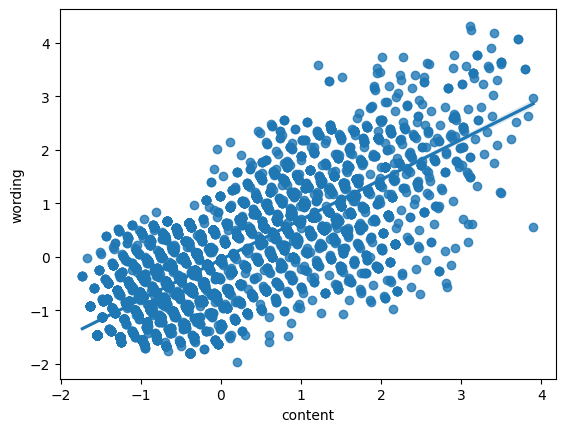

In [9]:
sns.regplot(x=train_df.content, y=train_df.wording)

We can also look at their joint distribution.

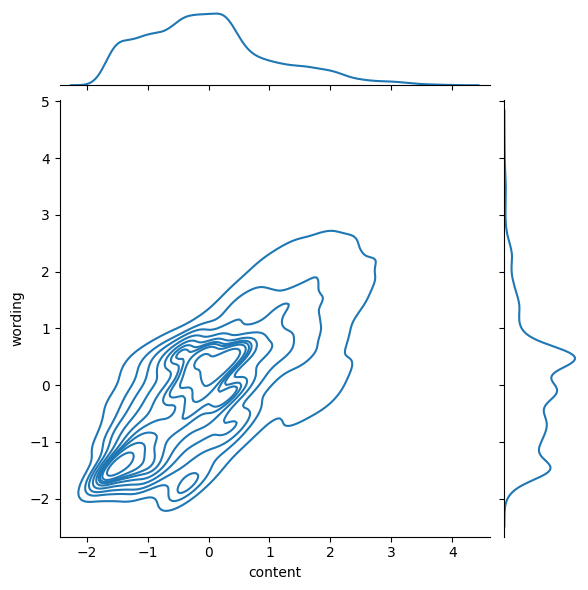

In [10]:
sns.jointplot(x=train_df.content, y=train_df.wording, kind="kde")

Looks like there are 2 discernible clusters

## Text Processing with fastai

### Tokenization

In [11]:
from fastai.text.all import *

In [12]:
sample_text = train_df.prompt_text[0][:200]
sample_text

'Background \r\nThe Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to'

#### Word Tokenization

The default english word tokenizer in fast ai uses the spaCy library.

In [13]:
spacy = WordTokenizer()
tokens = list(spacy([sample_text]))[0]
print(tokens)

['Background', '\r\n', 'The', 'Third', 'Wave', 'experiment', 'took', 'place', 'at', 'Cubberley', 'High', 'School', 'in', 'Palo', 'Alto', ',', 'California', 'during', 'the', 'first', 'week', 'of', 'April', '1967', '.', 'History', 'teacher', 'Ron', 'Jones', ',', 'finding', 'himself', 'unable', 'to', 'explain', 'to']


Fastai additionally includes some special tokens beginning with xx to encode information about the text like:

xxbos - indicate the beginning of stream

xxmaj - the next word is capitalized

xxunk - an unknown word

etc..

In [14]:
fast_tokenizer = Tokenizer(spacy)
tokens = list(fast_tokenizer(sample_text))
print(tokens)

['xxbos', 'xxmaj', 'background', '\r\n', 'xxmaj', 'the', 'xxmaj', 'third', 'xxmaj', 'wave', 'experiment', 'took', 'place', 'at', 'xxmaj', 'cubberley', 'xxmaj', 'high', 'xxmaj', 'school', 'in', 'xxmaj', 'palo', 'xxmaj', 'alto', ',', 'xxmaj', 'california', 'during', 'the', 'first', 'week', 'of', 'xxmaj', 'april', '1967', '.', 'xxmaj', 'history', 'teacher', 'xxmaj', 'ron', 'xxmaj', 'jones', ',', 'finding', 'himself', 'unable', 'to', 'explain', 'to']


The rules applied can be listed and inspected:

In [15]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html(x)>,
 <function fastai.text.core.replace_rep(t)>,
 <function fastai.text.core.replace_wrep(t)>,
 <function fastai.text.core.spec_add_spaces(t)>,
 <function fastai.text.core.rm_useless_spaces(t)>,
 <function fastai.text.core.replace_all_caps(t)>,
 <function fastai.text.core.replace_maj(t)>,
 <function fastai.text.core.lowercase(t, add_bos=True, add_eos=False)>]

In [16]:
replace_wrep??

Signature: replace_wrep(t)
Source:   
def replace_wrep(t):
    "Replace word repetitions: word word word word -- TK_WREP 4 word"
    def _replace_wrep(m):
        c,cc,e = m.groups()
        return f' {TK_WREP} {len(cc.split())+2} {c} {e}'
    return _re_wrep.sub(_replace_wrep, t)
File:      /opt/conda/lib/python3.10/site-packages/fastai/text/core.py
Type:      function

#### Sub-word Tokenization

To use a sub-word tokenizer, we supply the size of the vocabulary. The tokenizer will then need a corpus of text to train its vocabulary on, using the `setup` method. To demonstrate, we'll use the prompt texts to derive the vocabulary, then display tokens for the sample text.

In [17]:
def subwords(size):
    tokenizer = SubwordTokenizer(vocab_sz=size)
    tokenizer.setup(texts)
    return list(tokenizer([sample_text]))[0]

texts = list(prompts_train_df.prompt_text)

In [18]:
print(subwords(1000))

['▁B', 'ack', 'grou', 'nd', '▁The', '▁Thi', 'rd', '▁Wave', '▁experiment', '▁to', 'ok', '▁place', '▁at', '▁Cu', 'b', 'ber', 'le', 'y', '▁H', 'igh', '▁S', 'chool', '▁in', '▁Pa', 'lo', '▁Al', 'to', ',', '▁C', 'ali', 'for', 'n', 'ia', '▁du', 'r', 'ing', '▁the', '▁first', '▁week', '▁of', '▁A', 'pri', 'l', '▁1', '9', '6', '7', '.', '▁Hi', 's', 'tory', '▁t', 'each', 'er', '▁R', 'on', '▁Jones', ',', '▁fin', 'ding', '▁him', 'sel', 'f', '▁un', 'a', 'ble', '▁to', '▁ex', 'plain', '▁to']


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=tmp/texts.out --vocab_size=1000 --model_prefix=tmp/spm --character_coverage=0.99999 --model_type=unigram --unk_id=9 --pad_id=-1 --bos_id=-1 --eos_id=-1 --minloglevel=2 --user_defined_symbols=▁xxunk,▁xxpad,▁xxbos,▁xxeos,▁xxfld,▁xxrep,▁xxwrep,▁xxup,▁xxmaj --hard_vocab_limit=false


In [19]:
print(subwords(100))

['▁', 'B', 'a', 'c', 'k', 'g', 'r', 'o', 'u', 'n', 'd', '▁', 'T', 'h', 'e', '▁', 'T', 'h', 'i', 'r', 'd', '▁', 'W', 'a', 'v', 'e', '▁', 'e', 'x', 'p', 'er', 'i', 'm', 'en', 't', '▁to', 'o', 'k', '▁p', 'l', 'a', 'c', 'e', '▁', 'at', '▁', 'C', 'u', 'b', 'b', 'er', 'le', 'y', '▁', 'H', 'i', 'g', 'h', '▁', 'S', 'c', 'h', 'o', 'o', 'l', '▁in', '▁', 'P', 'a', 'l', 'o', '▁', 'A', 'l', 't', 'o', ',', '▁', 'C', 'a', 'l', 'i', 'f', 'or', 'n', 'i', 'a', '▁', 'd', 'u', 'r', 'ing', '▁the', '▁', 'f', 'i', 'r', 'st', '▁w', 'e', 'e', 'k', '▁of', '▁', 'A', 'p', 'r', 'i', 'l', '▁', '1', '9', '6', '7', '.', '▁', 'H', 'i', 'st', 'or', 'y', '▁', 't', 'e', 'a', 'c', 'h', 'er', '▁', 'R', 'on', '▁', 'J', 'on', 'e', 's', ',', '▁', 'f', 'in', 'd', 'ing', '▁', 'h', 'i', 'm', 's', 'e', 'l', 'f', '▁', 'u', 'n', 'a', 'b', 'le', '▁to', '▁', 'e', 'x', 'p', 'l', 'a', 'in', '▁to']


The larger the vocab size, the larger each token is, approaching the size of individual words. This results in less tokens per sentence meaning, a smaller model that is faster to train and there's less for the model to remember. However, it requires a large embedding matrix that needs more data to train.

### Numericalization

For demonstration purposes, we'll use the word tokenizer created above:

In [20]:
print(fast_tokenizer(sample_text))

['xxbos', 'xxmaj', 'background', '\r\n', 'xxmaj', 'the', 'xxmaj', 'third', 'xxmaj', 'wave', 'experiment', 'took', 'place', 'at', 'xxmaj', 'cubberley', 'xxmaj', 'high', 'xxmaj', 'school', 'in', 'xxmaj', 'palo', 'xxmaj', 'alto', ',', 'xxmaj', 'california', 'during', 'the', 'first', 'week', 'of', 'xxmaj', 'april', '1967', '.', 'xxmaj', 'history', 'teacher', 'xxmaj', 'ron', 'xxmaj', 'jones', ',', 'finding', 'himself', 'unable', 'to', 'explain', 'to']


We create a list of tokens for each of the prompt texts i.e. our demo corpus.

In [21]:
text_tokens = list(map(fast_tokenizer, texts))
text_tokens

[(#744) ['xxbos','xxmaj','chapter','13','\r\n','xxmaj','as','the','sequel','to'...],
 (#711) ['xxbos','xxmaj','egyptian','society','was','structured','like','a','pyramid','.'...],
 (#723) ['xxbos','xxmaj','background','\r\n','xxmaj','the','xxmaj','third','xxmaj','wave'...],
 (#1150) ['xxbos','xxmaj','with','one','member','trimming','beef','in','a','cannery'...]]

We'll need to train the numbericalizer with tokens from the corpus, which happens in the setup method, as in the subword tokenizer above. This results in a vocab attribute where the index of the token is the number associated with the token

In [22]:
numericalize = Numericalize()
numericalize.setup(text_tokens)
numericalize.vocab[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 ',',
 '.',
 'of',
 'and',
 'to',
 'a',
 'in',
 'it',
 'that',
 '\r\n']

The vocab starts with the special tokens, then the rest of the vocab in order of frequency in the corpus.

With the default parameters to Numericalize, each token needs to appear at least 3 times to be included in the vocabulary, set by`min_freq`. The maximum size of the vocabulary `max_vocab`, is set to 60000, so only the most 60k frequent tokens will be included. Every other token will be assigned the unknown marker `xxunk`.

This helps limit the embeddings from being too large, and using up a lot of memory, while also excluding tokens that have insufficient representation in the training data to be learned.

In [23]:
numericalize??

Signature:   numericalize(x, **kwargs)
Type:        Numericalize
String form:
Numericalize:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes
File:        /opt/conda/lib/python3.10/site-packages/fastai/text/data.py
Source:     
class Numericalize(Transform):
    "Reversible transform of tokenized texts to numericalized ids"
    def __init__(self, vocab=None, min_freq=3, max_vocab=60000, special_toks=None):
        store_attr('vocab,min_freq,max_vocab,special_toks')
        self.o2i = None if vocab is None else defaultdict(int, {v:k for k,v in enumerate(vocab)})

    def setups(self, dsets):
        if dsets is None: return
        if self.vocab is None:
            count = dsets.counter if getattr(dsets, 'counter', None) is not None else Counter(p for o in dsets for p in o)
            if self.special_toks is None and hasattr(dsets, 'special_toks'):
                self.special_toks = dsets.special_toks
            self.vocab = make_vocab(count, min_freq=self.min_

We can then tokenize and numericalize the sample text.

In [24]:
tokens = fast_tokenizer(sample_text)
print(tokens)

['xxbos', 'xxmaj', 'background', '\r\n', 'xxmaj', 'the', 'xxmaj', 'third', 'xxmaj', 'wave', 'experiment', 'took', 'place', 'at', 'xxmaj', 'cubberley', 'xxmaj', 'high', 'xxmaj', 'school', 'in', 'xxmaj', 'palo', 'xxmaj', 'alto', ',', 'xxmaj', 'california', 'during', 'the', 'first', 'week', 'of', 'xxmaj', 'april', '1967', '.', 'xxmaj', 'history', 'teacher', 'xxmaj', 'ron', 'xxmaj', 'jones', ',', 'finding', 'himself', 'unable', 'to', 'explain', 'to']


In [25]:
nums = numericalize(tokens)
nums

TensorText([  2,   8,   0,  19,   8,   9,   8, 102,   8, 123,  70, 173, 107,
             49,   8,   0,   8,   0,   8,   0,  16,   8,   0,   8,   0,  10,
              8,   0,   0,   9,  73, 174,  12,   8,   0,   0,  11,   8,   0,
              0,   8,   0,   8,  39,  10,   0,   0,   0,  14,   0,  14])

This is how we'd reconstruct the tokenized stream from the numericalized stream:

In [26]:
" ".join([numericalize.vocab[n] for n in nums])

'xxbos xxmaj xxunk \r\n xxmaj the xxmaj third xxmaj wave experiment took place at xxmaj xxunk xxmaj xxunk xxmaj xxunk in xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxunk the first week of xxmaj xxunk xxunk . xxmaj xxunk xxunk xxmaj xxunk xxmaj jones , xxunk xxunk xxunk to xxunk to'

Notice that we have many xxunk's, probably because of such a small corpus. We can set `min_freq` to 1 for demo purposes.

In [27]:
numericalize = Numericalize(min_freq=1)
numericalize.setup(text_tokens)

tokens = fast_tokenizer(sample_text)
nums = numericalize(tokens)
" ".join([numericalize.vocab[n] for n in nums])

'xxbos xxmaj background \r\n xxmaj the xxmaj third xxmaj wave experiment took place at xxmaj cubberley xxmaj high xxmaj school in xxmaj palo xxmaj alto , xxmaj california during the first week of xxmaj april 1967 . xxmaj history teacher xxmaj ron xxmaj jones , finding himself unable to explain to'

### Batching text for the language Model

We need to pass the stream of tokens to the language model in equal sized batches. At the same time, we also need to preserve the sequence of words which will help the model learn their ordering. Below is a demonstration of we would batch the token stream to a given batch size while retaining sequential order.

In [28]:
tokens = fast_tokenizer(sample_text)
batch_size, sequence_length = 5, 10
batches = [tokens[i*sequence_length:(i+1)*sequence_length] for i in range(batch_size)]
df = pd.DataFrame(batches)
df

,0,1,2,3,4,5,6,7,8,9
0,xxbos,xxmaj,background,\r\n,xxmaj,the,xxmaj,third,xxmaj,wave
1,experiment,took,place,at,xxmaj,cubberley,xxmaj,high,xxmaj,school
2,in,xxmaj,palo,xxmaj,alto,",",xxmaj,california,during,the
3,first,week,of,xxmaj,april,1967,.,xxmaj,history,teacher
4,xxmaj,ron,xxmaj,jones,",",finding,himself,unable,to,explain


However, since the input to the language model may be millions of tokens, we'll need to divide the batches into sub-arrays that can fit into the GPU. Below is a demo of how we'd take a potentially large input token stream and only pass in small batches at a time. Note that compared to the above example, we take care to begin the next batch for each row exactly where the previous one ended. The model which remembers state is therefore able to learn the ordered sequence of tokens.

First batch:

In [29]:
batch_size, sequence_length = 5, 3
batches = [tokens[i*10: i*10+3] for i in range(batch_size)]
pd.DataFrame(batches)

,0,1,2
0,xxbos,xxmaj,background
1,experiment,took,place
2,in,xxmaj,palo
3,first,week,of
4,xxmaj,ron,xxmaj


The second batch:

In [30]:
pd.DataFrame([tokens[i*10+3: i*10+(2*3)] for i in range(batch_size)])

,0,1,2
0,\r\n,xxmaj,the
1,at,xxmaj,cubberley
2,xxmaj,alto,","
3,xxmaj,april,1967
4,jones,",",finding


The third batch:

In [31]:
pd.DataFrame([tokens[i*10+(2*3): i*10+(3*3)] for i in range(batch_size)])

,0,1,2
0,xxmaj,third,xxmaj
1,xxmaj,high,xxmaj
2,xxmaj,california,during
3,.,xxmaj,history
4,himself,unable,to


And so on..

This will be taken care of under the hood with fastai's LMDataLoader. At the beginning of each epoch, the list of documents will be shuffled then concatenated.

The list is then divided into ministreams of the given batch size that will be fed into the model concurrently in equal sized slices to the model.

In [32]:
numericalized_tokens = list(map(numericalize, text_tokens))
dl = LMDataLoader(numericalized_tokens)

In [33]:
x, y = first(dl)
x.shape, y.shape

(torch.Size([64, 51]), torch.Size([64, 51]))

The dataloader has divided the text into 64 mini streams, and produces 51 tokens per stream per batch.

We can compare the independent and dependent sets used for training:

In [34]:
ministream_x, ministream_y = x[0], y[0]

print([numericalize.vocab[i] for i in ministream_x[:20]])

['xxbos', 'xxmaj', 'chapter', '13', '\r\n', 'xxmaj', 'as', 'the', 'sequel', 'to', 'what', 'has', 'already', 'been', 'said', ',', 'we', 'must', 'proceed', 'to']


In [35]:
print([numericalize.vocab[i] for i in ministream_y[:20]])

['xxmaj', 'chapter', '13', '\r\n', 'xxmaj', 'as', 'the', 'sequel', 'to', 'what', 'has', 'already', 'been', 'said', ',', 'we', 'must', 'proceed', 'to', 'consider']


Notice that the dependent set of tokens if offset by 1. This trains the model how to predict the next token.

### Fine Tuning the Language Model

We'll use the ULMFIT process to train the model for the scoring task. Using the model pre-trained on wikipedia data, we'll fine tune it on the text we have available for the task i.e. the prompts and summmaries, before training it to predict scores.

For our fine-tuning corpus, we'll assemble texts from the prompts and summaries, i.e. the prompt questions, prompt texts and summaries texts.

In [36]:
df_1 = prompts_train_df[['prompt_question']].rename(columns={"prompt_question": "text"})
df_2 = prompts_train_df[['prompt_text']].rename(columns={"prompt_text": "text"})
df_3 = summ_train_df[['text']]
corpus_df = pd.concat([df_1, df_2, df_3], ignore_index=True)
corpus_df

,text
0,"Summarize at least 3 elements of an ideal tragedy, as described by Aristotle."
1,"In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text."
2,Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
3,Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.
4,"Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosp..."
...,...
7168,"They used all sorts of chemical concoctions to make the meat seem fine, as shown in this quote, ""also of all the miracles of chemistry which they performed, giving to any sort of meat, fresh or salted, whole or chopped, any color and any flavor and any odor they chose."" This quote shows just how much power they had in the manipulation of people and meat."
7169,"The lowest classes are slaves and farmers slaves being people taken from war and farmers pay a huge tax. The middle class was the craftsmen and craftswomen and the physicians. The higher class was the Nobles, Scribes, Pharaoh's, Soldiers and the Preist."
7170,they sorta made people start working on the structour theyed barley got paid.if they didget payed it was barley half of they actually had to get. one good ting is that the vizier's learned ho to read & write thats a really rare skill to masterin ainceint egypt.
7171,"An ideal tragety has three elements that make it ideal. To start a great tragedy must start with a great man and story, then to follow with a great twist or massive change in events. Lastly a great tragedy can be so good that in the end the man comes full circle and ends up with a good ending."


This give a corpus of about 7k pieces of text.

We can use the TextDataLoaders class to create a fastai dataloader from fine tuning corpus. This will take care of tokenization and numericalization under the hood. We'll use a random 10% sample for validation.

However, we need to add special tokens that will be used in fine tuning for the final prediction task so that embeddings are created for them.

In [37]:
custom_tokens = ["<prompt_title>", "<prompt_text>", "<prompt_question>", "<summary>"]
special_tokens = defaults.text_spec_tok + custom_tokens
custom_tokenizer = WordTokenizer(special_toks=special_tokens)

In [38]:
custom_tokens_text = (" ".join(custom_tokens * 3))
custom_t_df = pd.DataFrame(data=dict(text=[custom_tokens_text]))
corpus_df = pd.concat([corpus_df, custom_t_df], ignore_index=True)
corpus_df

,text
0,"Summarize at least 3 elements of an ideal tragedy, as described by Aristotle."
1,"In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text."
2,Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
3,Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.
4,"Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosp..."
...,...
7169,"The lowest classes are slaves and farmers slaves being people taken from war and farmers pay a huge tax. The middle class was the craftsmen and craftswomen and the physicians. The higher class was the Nobles, Scribes, Pharaoh's, Soldiers and the Preist."
7170,they sorta made people start working on the structour theyed barley got paid.if they didget payed it was barley half of they actually had to get. one good ting is that the vizier's learned ho to read & write thats a really rare skill to masterin ainceint egypt.
7171,"An ideal tragety has three elements that make it ideal. To start a great tragedy must start with a great man and story, then to follow with a great twist or massive change in events. Lastly a great tragedy can be so good that in the end the man comes full circle and ends up with a good ending."
7172,"The meat would smell sour but the would ""rub it up with soda to take away the smell"" and they then would sell this rotting meat. Hams would be found spoiled after being pickled so they would pump it with a ""stronger pickle"" to make the odor go away. They would sell ham that they had taken the bone out of and use a white hot iron to be sold a s a boneless ham. Meat would fall on the floor and was stored in unsanitary places until sold to the public. Meat was contaminated with chemicals to make it look fresh and not rotted."


In [39]:
lm_dataloaders = TextDataLoaders.from_df(
    corpus_df,
    text_col='text',
    is_lm=True,
    tok_tfm=custom_tokenizer,
    valid_pct=0.1,
    seed=42
)

Since we're training a language model, the dataloader know's how to offset the text by one word. We can see a sample batch of the independent and dependent texts.

In [40]:
lm_dataloaders.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj the 3 elements of an ideal tragedy is xxunk no single tragic quality , it neither satisfies the moral sense nor calls forth pity or fear and should go from adversity to prosperity . xxbos xxmaj the different social classes were involved in this goverment by , the people with the less important jobs were at the bottom , and the richer but not completely rich was the middle class","xxmaj the 3 elements of an ideal tragedy is xxunk no single tragic quality , it neither satisfies the moral sense nor calls forth pity or fear and should go from adversity to prosperity . xxbos xxmaj the different social classes were involved in this goverment by , the people with the less important jobs were at the bottom , and the richer but not completely rich was the middle class ."
1,""" slavery became the fate of those captured as prisoners of war . "" xxmaj slaves were forced to work on building projects and other difficult tasks that only people on the lowest level of the social class pyramid would do . xxmaj the article says "" farmers tended fields , raised animals , kept canals and reservoirs in good order , worked in the stone quarries and built the royal monuments","slavery became the fate of those captured as prisoners of war . "" xxmaj slaves were forced to work on building projects and other difficult tasks that only people on the lowest level of the social class pyramid would do . xxmaj the article says "" farmers tended fields , raised animals , kept canals and reservoirs in good order , worked in the stone quarries and built the royal monuments ."
2,pharoah or a noble or if you were unlucky a slave ? xxup egyptian xxup social xxup structure tells you all about the egyptian social structure . xxbos xxmaj it developed over short period of time through it become such a strong movement that xxunk gathered in . xxmaj it was ended because they worried that it would lead peope to xxunk doing horrible things in the name o the states honor,or a noble or if you were unlucky a slave ? xxup egyptian xxup social xxup structure tells you all about the egyptian social structure . xxbos xxmaj it developed over short period of time through it become such a strong movement that xxunk gathered in . xxmaj it was ended because they worried that it would lead peope to xxunk doing horrible things in the name o the states honor .


In [41]:
"<summary>" in lm_dataloaders.vocab

True

Next we create a learner using the AWD_LSTM recurrent neural network architecture. We'll use accuracy and perplexity metrics (perplexity is exponent of the loss function, cross entropy).

In [42]:
learner = language_model_learner(
    lm_dataloaders,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()]
).to_fp16()

Next we fine-tune the model for one epoch. By default the model learner freezes the model layers, so only the randomly initialized embeddings for the new vocabulary will be trained.


In [43]:
learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.695058,2.449276,0.498326,11.579957,00:26


Next, we unfreeze the model and train it for additional epochs.

In [44]:
learner.unfreeze()
learner.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.262797,2.237536,0.531681,9.370212,00:28
1,2.073195,2.144167,0.546974,8.534926,00:34
2,1.820991,2.154963,0.549172,8.627569,00:35


We now have a language model fine tuned on the prompts and summaries. We can try generate some text using a random prompt.

In [45]:
prompt = "I liked this movie because"
print(prompt)
n_words, n_sentences = 40, 2

preds = [learner.predict(prompt, n_words, temperature=0.75) for _ in range(n_sentences)]
print("\n\n".join(preds))

I liked this movie because


i liked this movie because it makes it more interesting and interesting . He also said that it must be a comedy . In paragraph 2 it says that they would rub the meat with soda so it would nt be known

i liked this movie because he wanted to see how fast the group were getting out of hand and what was happening and what he was doing . Three elements of an ideal tragedy are one that the main character must be someone


In [46]:
learner.save_encoder('finetuned_lm')

## Feature Engineering

We need a way to now pass in the our independent variables (prompt text and summary text) and the target variables (content and wording). Given that we have two targets, we'll need two separate models for each variable.

As input to the model, we'll need to combine the prompt and summary columns into a single text stream that the model learns from. Need to somehow delineat the different fields in the stream in a way the model can learn to pick them out.

We'll use the special tokens added via the custom tokenizer.

In [47]:
special_tokens

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 '<prompt_title>',
 '<prompt_text>',
 '<prompt_question>',
 '<summary>']

In [48]:
def add_combined_column(df):
    separator = " " * 100
    df['inputs'] = ('<prompt_title>' +
                    df.prompt_title +
                    '<prompt_text>' +
                    df.prompt_text +
                    '<prompt_question>' +
                    df.prompt_question +
                    '<summary>' +
                    df.text)
    return df

train_df = add_combined_column(train_df)
test_df = add_combined_column(test_df)

In [49]:
train_df.inputs[0]

'<prompt_title>The Third Wave<prompt_text>Background \r\nThe Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline, strength through community, strength through action, strength through pride.” \r\nThe Experiment \r\nJo

## Training, Validation, Testing sets

According to this [discussion][4], we expect unseen prompts in the test set. So to start with, we'll use a single fold from a GroupKFold splitter, which will give us a validation set with a prompt not in the training set.

[4]: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/424402#2357564

In [50]:
from sklearn.model_selection import GroupKFold
random.seed(42)

group_k_fold = GroupKFold(n_splits=4)
folds = list(group_k_fold.split(train_df, groups=train_df.prompt_id))

We select the validation rows by ids from the fold.

In [51]:
train_ids, val_ids = folds[0]
train_ids, val_ids

train_df['is_validation'] = False
train_df.iloc[val_ids, 9] = True
train_df['is_validation'].value_counts()

is_validation
False    5108
True     2057
Name: count, dtype: int64

# Fit Model

We'll need two models, since we're predicting each of the content and wording scores

In [74]:
content_dls = TextDataLoaders.from_df(
    train_df,
    text_col='inputs',
    label_col='content',
    y_block=RegressionBlock,
    text_vocab=lm_dataloaders.vocab,
    tok_tfm=custom_tokenizer,
    seed=42
)

The text needs to be passed to the model during training using equal sized tensors. Fast AI will help in this regard by sorting the text inputs by size, then for each batch, pad them to the largest size in the batch.

In [75]:
content_dls.show_batch(max_n=3)

,text,category
0,"xxbos <prompt_title> excerpt from xxmaj the jungle <prompt_text> with one member trimming beef in a cannery , and another working in a sausage factory , the family had a first - hand knowledge of the great majority of xxmaj packingtown swindles . xxmaj for it was the custom , as they found , whenever meat was so spoiled that it could not be used for anything else , either to can it or else to chop it up into sausage . xxmaj with what had been told them by xxmaj jonas , who had worked in the pickle rooms , they could now study the whole of the spoiled - meat industry on the inside , and read a new and grim meaning into that old xxmaj packingtown jest — that they use everything of the pig except the squeal . \r\n xxmaj jonas had told them how the meat",3.08506869892915
1,"xxbos <prompt_title> excerpt from xxmaj the jungle <prompt_text> with one member trimming beef in a cannery , and another working in a sausage factory , the family had a first - hand knowledge of the great majority of xxmaj packingtown swindles . xxmaj for it was the custom , as they found , whenever meat was so spoiled that it could not be used for anything else , either to can it or else to chop it up into sausage . xxmaj with what had been told them by xxmaj jonas , who had worked in the pickle rooms , they could now study the whole of the spoiled - meat industry on the inside , and read a new and grim meaning into that old xxmaj packingtown jest — that they use everything of the pig except the squeal . \r\n xxmaj jonas had told them how the meat",3.20924836058688
2,"xxbos <prompt_title> excerpt from xxmaj the jungle <prompt_text> with one member trimming beef in a cannery , and another working in a sausage factory , the family had a first - hand knowledge of the great majority of xxmaj packingtown swindles . xxmaj for it was the custom , as they found , whenever meat was so spoiled that it could not be used for anything else , either to can it or else to chop it up into sausage . xxmaj with what had been told them by xxmaj jonas , who had worked in the pickle rooms , they could now study the whole of the spoiled - meat industry on the inside , and read a new and grim meaning into that old xxmaj packingtown jest — that they use everything of the pig except the squeal . \r\n xxmaj jonas had told them how the meat",0.971054220625594


The competition uses the MCRMSE metric, of which some explanations have been linked to [here][1]

[1]: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/424162

It is essentially the mean of the RMSE scores for each of the two dependent variables. So we'll use the RMSE of each of the two models. We'll also experiment with some hyperparameters

In [76]:
MSELossFlat??

Signature:
MSELossFlat(
    *args,
    axis: 'int' = -1,
    floatify: 'bool' = True,
    reduction='mean',
)
Source:   
@use_kwargs_dict(reduction='mean')
def MSELossFlat(
    *args, 
    axis:int=-1, # Class axis
    floatify:bool=True, # Convert `targ` to `float`
    **kwargs
):
    "Same as `nn.MSELoss`, but flattens input and target."
    return BaseLoss(nn.MSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
File:      /opt/conda/lib/python3.10/site-packages/fastai/losses.py
Type:      function

In [80]:
content_learner = text_classifier_learner(content_dls, AWD_LSTM, drop_mult=0.5, loss_func=MSELossFlat, metrics=rmse)

In [81]:
content_learner = content_learner.load_encoder('finetuned_lm')

In [82]:
content_learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,_rmse,time


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [73]:
content_learner.metrics

(#1) [<fastai.metrics.AccumMetric object at 0x7a18d5a25390>]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

# overfitting example
X, y = x_y(std_train_df)
m = RandomForestRegressor(n_jobs=-1)
m.fit(X, y.content)
preds = m.predict(X)
math.sqrt(mean_squared_error(y.content, preds))

In [ ]:
from collections import defaultdict

def get_model_rmse(train_df, val_df, target, **model_kwargs):
    X_train, y_train = x_y(train_df)
    X_val, y_val = x_y(val_df)
    m = RandomForestRegressor(n_jobs=-1, **model_kwargs)
    m.fit(X_train, y_train[target])
    preds = m.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val[target], preds))
    return m, rmse

In [ ]:
results = dict(content=defaultdict(list), wording=defaultdict(list))

model_kwargs = dict(oob_score=True, n_estimators=300, random_state=42, max_features="sqrt", max_samples=0.3)

for target in results:
    for train_set, val_set in folds:
        train_df = std_train_df.iloc[train_set]
        val_df = std_train_df.iloc[val_set]
        model, rmse = get_model_rmse(train_df, val_df, target, **model_kwargs)
        results[target]['models'].append(model)
        results[target]['scores'].append(rmse)

content_mean_score = np.mean(results['content']['scores'])
wording_mean_score = np.mean(results['wording']['scores'])
overall_score = np.mean([content_mean_score, wording_mean_score])
content_mean_score, wording_mean_score, overall_score

We get an initial score of 0.76 with k-fold cross validation.

We can also show feature importances.

In [ ]:
def plot_feature_importance(models, columns, ax=None, title=None):
    feature_importances = [m.feature_importances_ for m in models]
    df_importances = pd.DataFrame(data=feature_importances, columns=columns)
    overall_importances = df_importances.sum().sort_values(ascending=False)
    overall_importances.plot(kind='barh', legend=False, ax=ax, title=title)    

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

for target, axis in [('content', ax1), ('wording', ax2)]:
    models = results[target]['models']
    plot_feature_importance(models, x_cols, axis, title=target)

# Inference

Make predictions on the test set. We get predictions across the model ensemble's by averaging them.

In [ ]:
X_test = std_test_df[x_cols]

content_preds = [m.predict(X_test) for m in results['content']['models']]
wording_preds = [m.predict(X_test) for m in results['wording']['models']]

content_avg_preds = np.stack(content_preds).mean(axis=0)
wording_avg_preds = np.stack(wording_preds).mean(axis=0)
content_avg_preds, wording_avg_preds

# Submission

In [ ]:
summ_test_df

In [ ]:
submission_df = summ_test_df.copy()
submission_df['content'] = content_avg_preds
submission_df['wording'] = wording_avg_preds
submission_df = submission_df[['student_id', 'content', 'wording']]
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)